# Ex11: トゥーンシェーディング

テクスチャを用意してトゥーンシェーディングをデザインしてみましょう．

## Ex11の実装部分

- texture_lookup_1d関数を実装してください

ヒント: 以下の要領で実装すればOKです．

```
# 画像の幅の取得
w = T.shape[1]

# Work: x座標の計算(以下を修正)
x = int(Iとwの式?)

# Work: x座標の位置の色はどう取得する？(以下を修正)
return T[?, ?, :]
```

xは画像の幅に対応するので，[0, w-1]まで動きます．
I: [0, 1]⇒x: [0, w-1]になるように変換式を作ってみましょう．

T[0, 0, :]は(x, y)=(0, 0)の位置の色を返しています．
一次元テクスチャの場合，y=0に固定できるので，(x, 0)の位置の色を返せばOKです．
xは，T[x, 0, :], T[0, x, :]のどちらでしょうか？



In [5]:
# Work: 以下の関数を修正．
def texture_lookup_1d(I, T):
  w = T.shape[1]
  x = int(I * (w - 1))
  return T[0,x, :]

## 補助関数

In [6]:
import cv2

# 拡散反射係数の計算
def diffuse_term(I_i, L, N):
  return I_i * np.dot(L, N)

# 鏡面反射係数の計算
def specular_term(I_i, H, N, alpha):
  return I_i * np.dot(H, N) ** alpha

# 画像読み込み
def imread(img_file):
  I = cv2.imread(img_file, -1)
  I = cv2.cvtColor(I, cv2.COLOR_BGRA2RGBA)
  return np.float32(I) / 255.0

# テクスチャ読み込み
def texread(img_file):
  I = cv2.imread(img_file)
  I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
  I = cv2.resize(I, dsize=(64, 10))
  return np.float32(I) / 255.0

# テクスチャ色からαチャンネルを構成
def texture_alpha(T):
  A = cv2.cvtColor(T, cv2.COLOR_RGB2GRAY)
  A = np.clip(10.0 * A, 0, 1)
  A = cv2.cvtColor(A, cv2.COLOR_GRAY2RGB)
  return A

# 1次元テクスチャのプロット
def plot_1d_texture(T_diffuse, T_specular):
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1, 2, 1)
  plt.imshow(T_diffuse)
  plt.axis("off")
  plt.title("Diffuse Texture")

  plt.subplot(1, 2, 2)
  plt.imshow(T_specular)
  plt.axis("off")
  plt.title("Specular Texture")

## Work: トゥーンシェーディングをデザインしてみましょう．

1. 自分でテクスチャをデザインしてください．
2. テクスチャが貼り付けられる様子を確認してください．

※ Colabの3D表示で計算できるのはフラットシェーディングだけです．

suzanne_smooth_2.obj
- numVertices:  31658
- numFaces:  31488


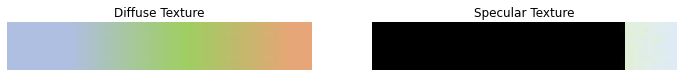

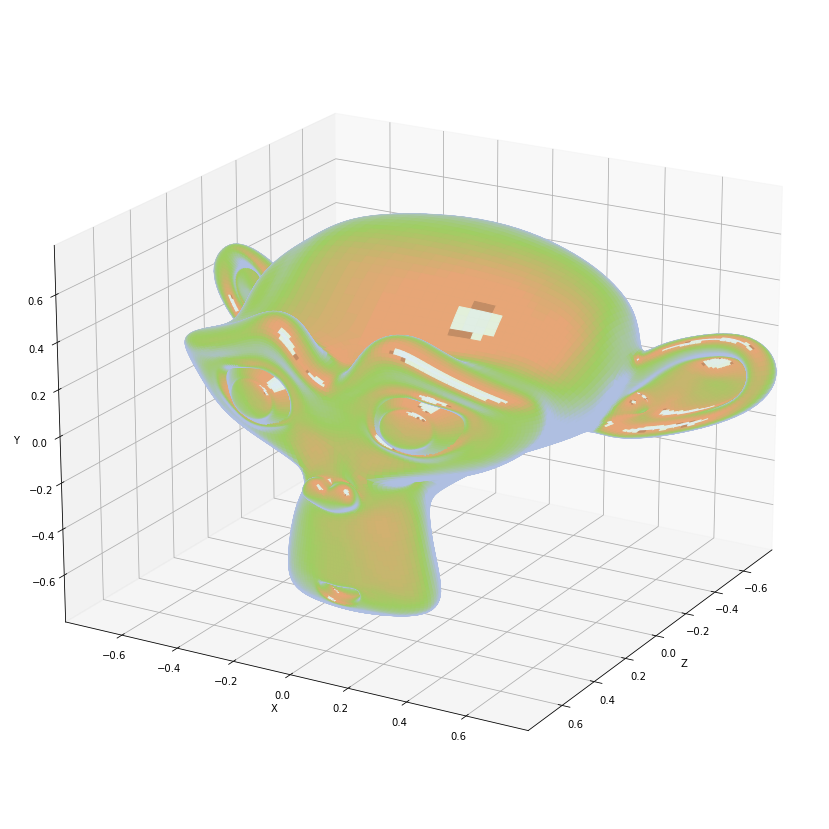

In [11]:
import numpy as np
from mesh import *
from transform import *

#@title Shadingパラメータ { run: "auto" }

#@markdown 入力ファイル
mesh_file = 'suzanne_smooth_2.obj' #@param {type:"string"}

#@markdown 入射光の強さ
I_diffuse =     1 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}
I_specular = 1 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}

#@markdown 拡散反射用テクスチャ
diffuse_file = 'toon_diffuse.png' #@param {type:"string"}
T_diffuse = texread(diffuse_file)

#@markdown 鏡面反射用テクスチャ
specular_file = 'toon_specular.png' #@param {type:"string"}
T_specular = texread(specular_file)
A_specular = texture_alpha(T_specular)

#@markdown ハイライトの鋭さ
alpha = 8 #@param {type: "slider", min: 0, max: 200}

#@markdown 光源方向の設定
lx = 0.5   #@param {type: "slider", min: -1.0, max: 1.0, step: 0.01}
ly = 0.81   #@param {type: "slider", min: -1.0, max: 1.0, step: 0.01}
lz = 1   #@param {type: "slider", min: -1.0, max: 1.0, step: 0.01}

#@markdown 視点パラメータ
elev = 20   #@param {type: "slider", min: 0, max: 90}
azim = 30   #@param {type: "slider", min: 0, max: 360}

mesh =  loadOBJ(mesh_file)
mesh.computeFaceNormals()

P = mesh.V
F = mesh.F
N_f = mesh.N_f

print(mesh_file)
print("- numVertices: ", len(P))
print("- numFaces: ", len(F))

# ライトベクトル
L = np.array([lx, ly, lz], dtype=np.float32)
L /= np.linalg.norm(L)

# 視線ベクトルの計算
R = rotate_y(azim) @ rotate_x(-elev)
V = np.array([0, 0, 1]) @ R[:3,:3].T

# ハーフベクトルの計算
H = L + V
H /= np.linalg.norm(H)


# 拡散反射の計算
I_d = [diffuse_term(I_diffuse, L, N) for N in N_f]
I_d = np.clip(I_d, 0, 1)
I_d = np.array([texture_lookup_1d(I, T_diffuse) for I in I_d])

# 鏡面反射の計算
I_s = [specular_term(I_specular, H, N, alpha) for N in N_f]
I_s = np.clip(I_s, 0, 1)

A_s = np.array([texture_lookup_1d(I, A_specular) for I in I_s])
I_s = np.array([texture_lookup_1d(I, T_specular) for I in I_s])


# 計算結果の組み合わせ
I = (1.0 - A_s) * I_d + A_s * I_s
I = np.clip(I, 0, 1)

plot_1d_texture(T_diffuse, T_specular)

fig = plt.figure(figsize=(15,15))

viewer = MeshViewer(fig)

viewer.addMesh(P, F, I,  edgecolor=I, alpha=1.0, linewidth=1.0)

viewer.setView(elev=elev, azim=azim)
viewer.show()

## レンダリング画像を使ったトゥーンシェーディング

レンダリング画像ではスムーズシェーディングが適用されているので滑らかな結果が得られます．

Text(0.5, 1.0, 'Toon Shading')

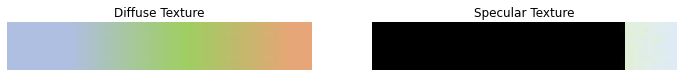

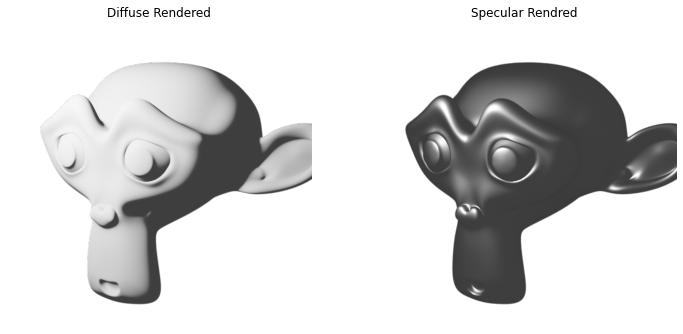

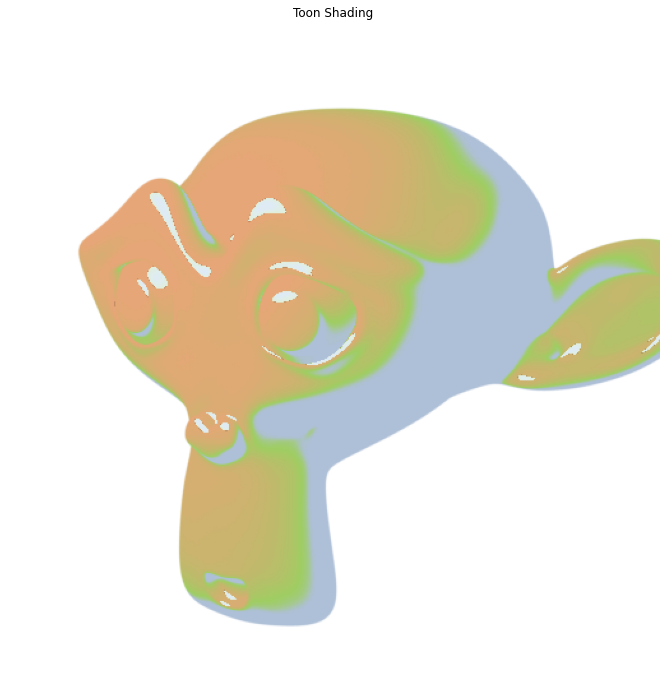

In [8]:
#@title Shadingパラメータ { run: "auto" }

#@markdown 拡散反射レンダリング画像
I_d_file = "render_diffuse.png"  #@param {type:"string"}
I_d = imread(I_d_file)
A = I_d[:,:,3]

#@markdown 鏡面反射レンダリング画像
I_s_file = "render_specular.png"  #@param {type:"string"}
I_s = imread(I_s_file)

plot_1d_texture(T_diffuse, T_specular)

fig = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(I_d)
plt.axis("off")
plt.title("Diffuse Rendered")

plt.subplot(1, 2, 2)
plt.imshow(I_s)
plt.axis("off")
plt.title("Specular Rendred")  

h, w = I_d.shape[:2]

# 拡散反射の計算
I_d =  cv2.cvtColor(I_d[:,:,:3], cv2.COLOR_RGB2GRAY)
I_d = np.array([texture_lookup_1d(I, T_diffuse) for I in I_d.flatten()])

# 鏡面反射の計算
I_s =  cv2.cvtColor(I_s[:,:,:3], cv2.COLOR_RGB2GRAY)
A_s = np.array([texture_lookup_1d(I, A_specular) for I in I_s.flatten()])
I_s = np.array([texture_lookup_1d(I, T_specular) for I in I_s.flatten()])

I = (1.0 - A_s) * I_d + A_s * I_s
I = np.clip(I, 0, 1)
I = I.reshape(h, w, 3)

fig = plt.figure(figsize=(12,12))
plt.subplot(1, 1, 1)
plt.imshow(np.dstack([I, A]))
plt.axis("off")
plt.title("Toon Shading")
